In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from utils.analysis_helpers import *

In [4]:
df = pd.read_csv('./topics/df_topic_OBE.csv')

# Palette for the topics
unique_topics = df['one_topic'].unique()
cmap = plt.get_cmap('tab20', len(unique_topics))
palette = {topic: mcolors.to_hex(cmap(i)) for i, topic in enumerate(sorted(unique_topics))}

In [5]:
df.head(2)

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,ID 05,1,"so, that was very, let's say, unexpected and s...",let unexpected surprising moment go realize ge...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']
1,ID 05,3,"a little bit it was a little bit like, okay, w...",watch outside special give lot emotion explain...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']


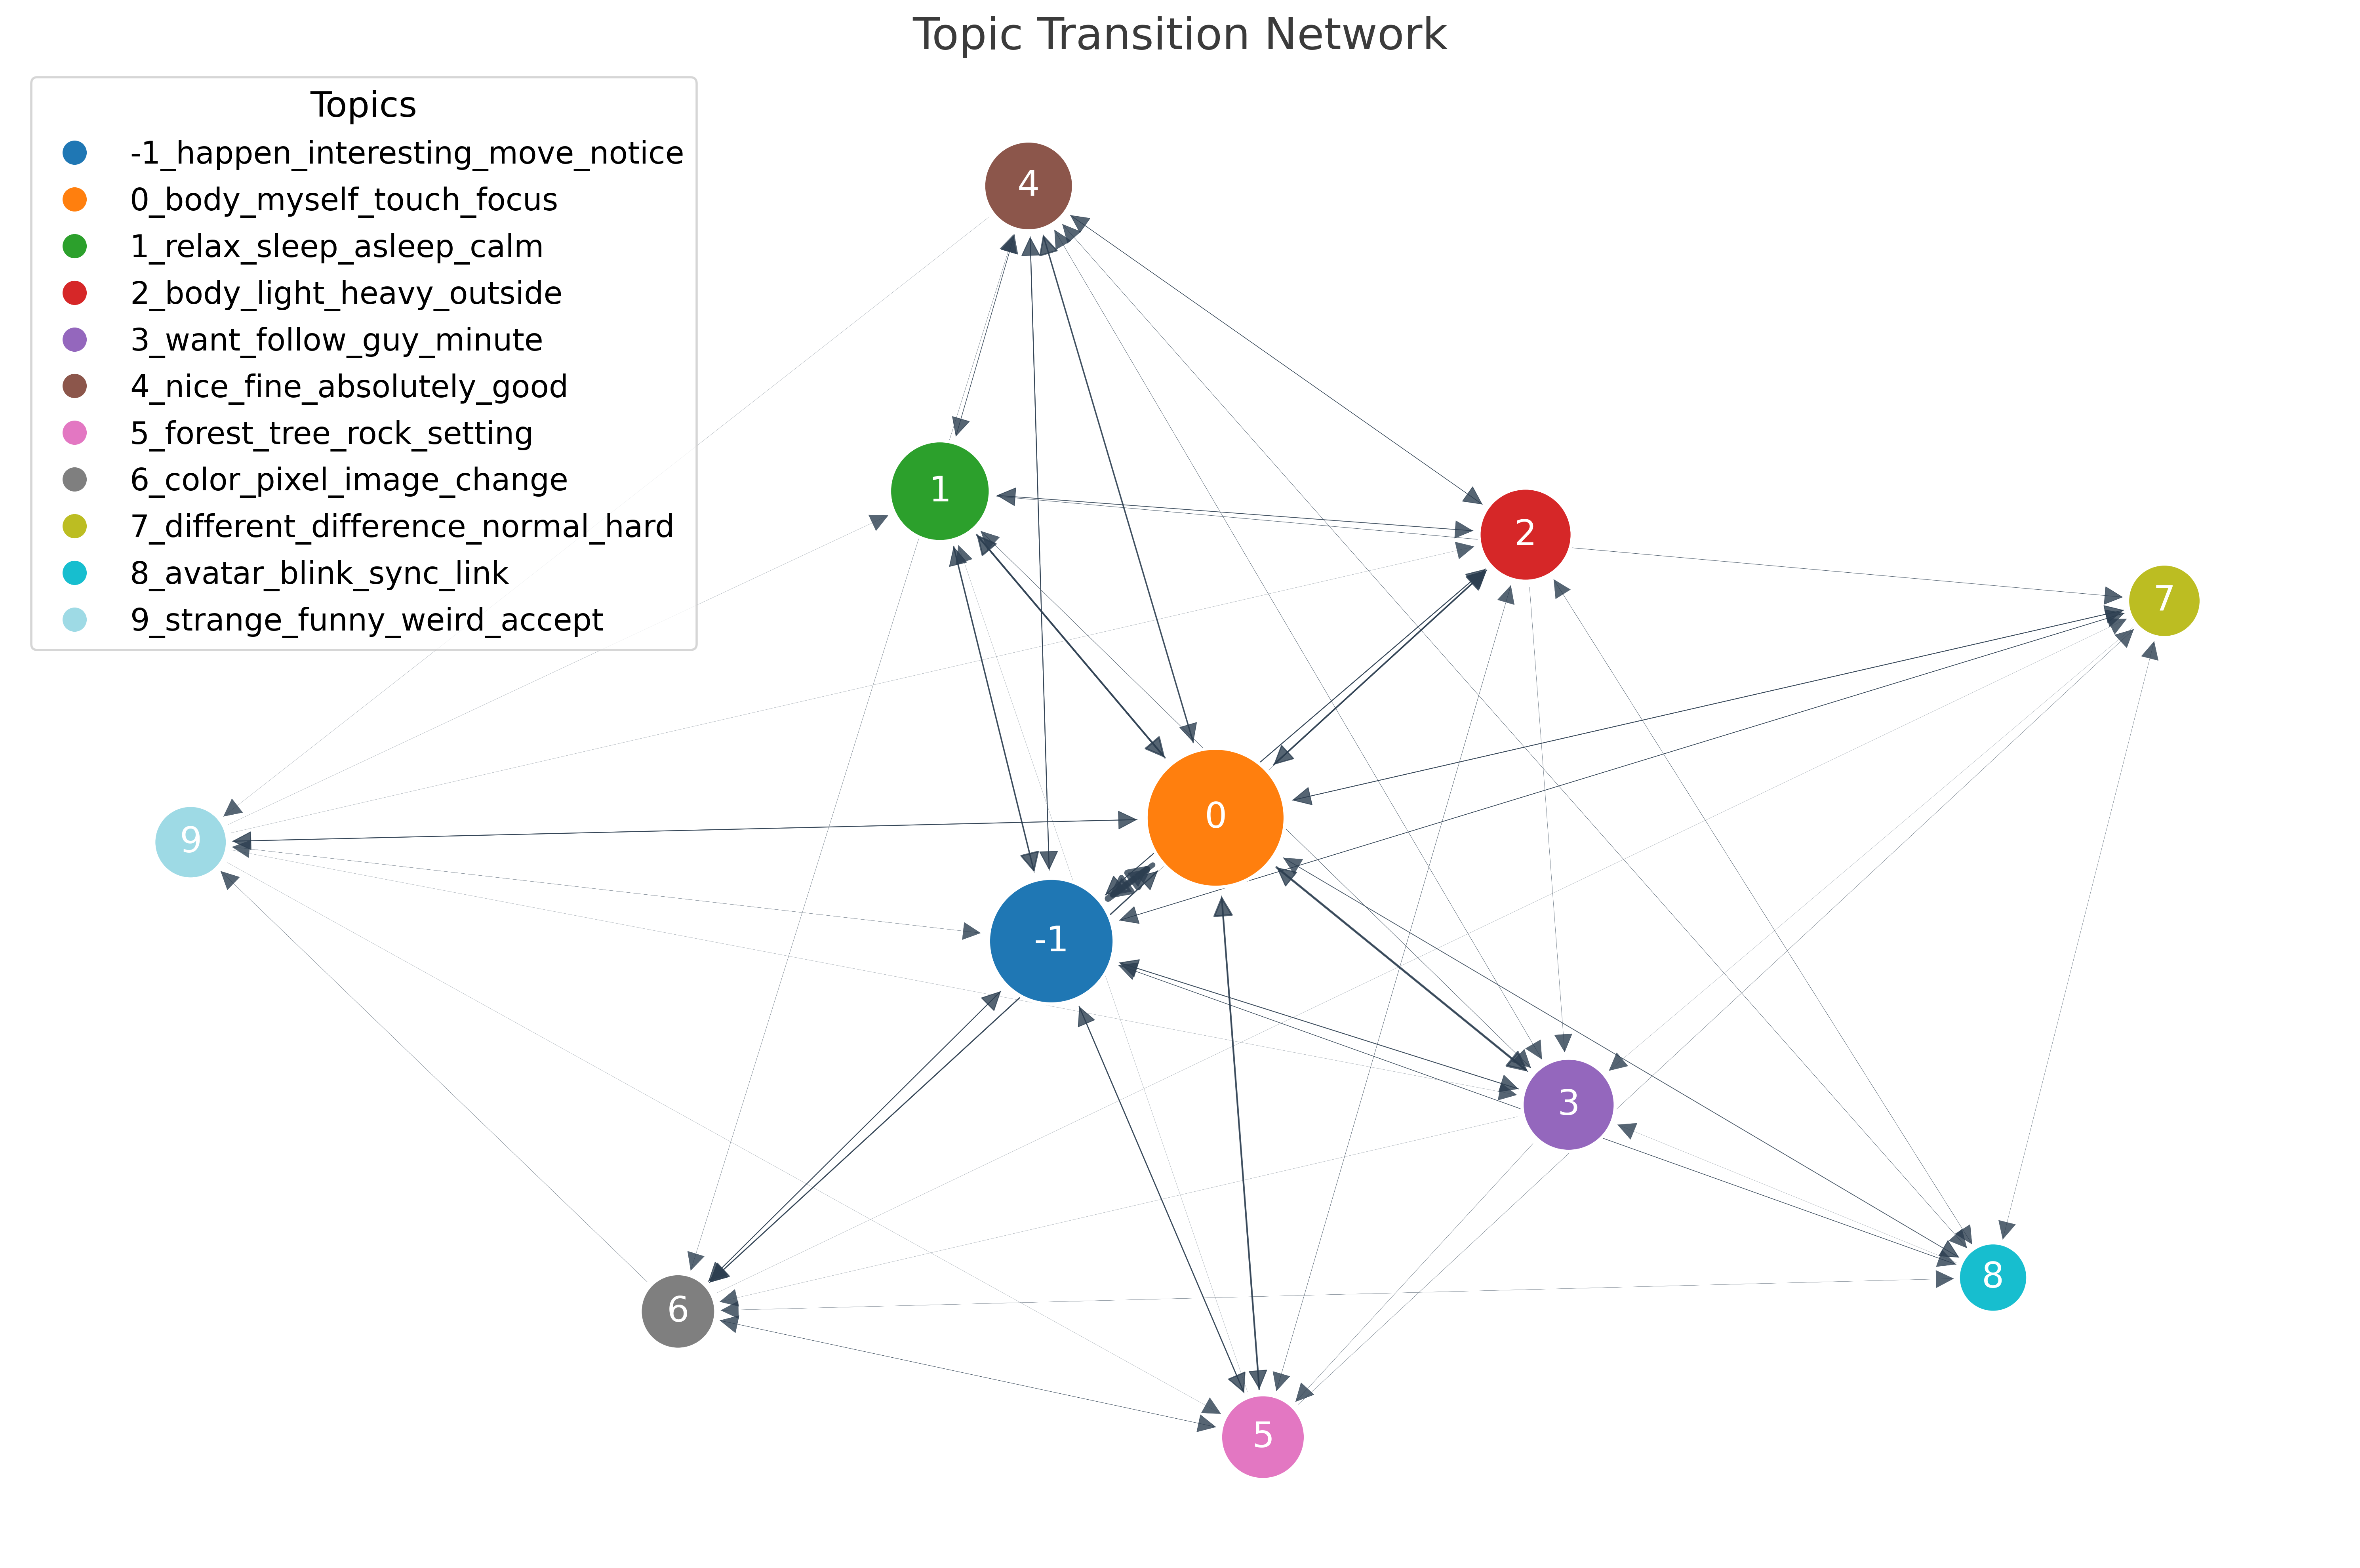

In [6]:
G = build_network_from_interviews(df, include_self_loops=False)
plot_topic_transition_network(G, show_edge_labels=False, palette=palette, size_by="appearance", file_name="outputs/images/topic_network_OBE") # appearance , occurrence ,degree_centrality

In [7]:
# for file in df["File Name"].unique():
#     print(file)
#     G_single = build_network_from_interviews(df[df["File Name"] == file], include_self_loops=False)
#     plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

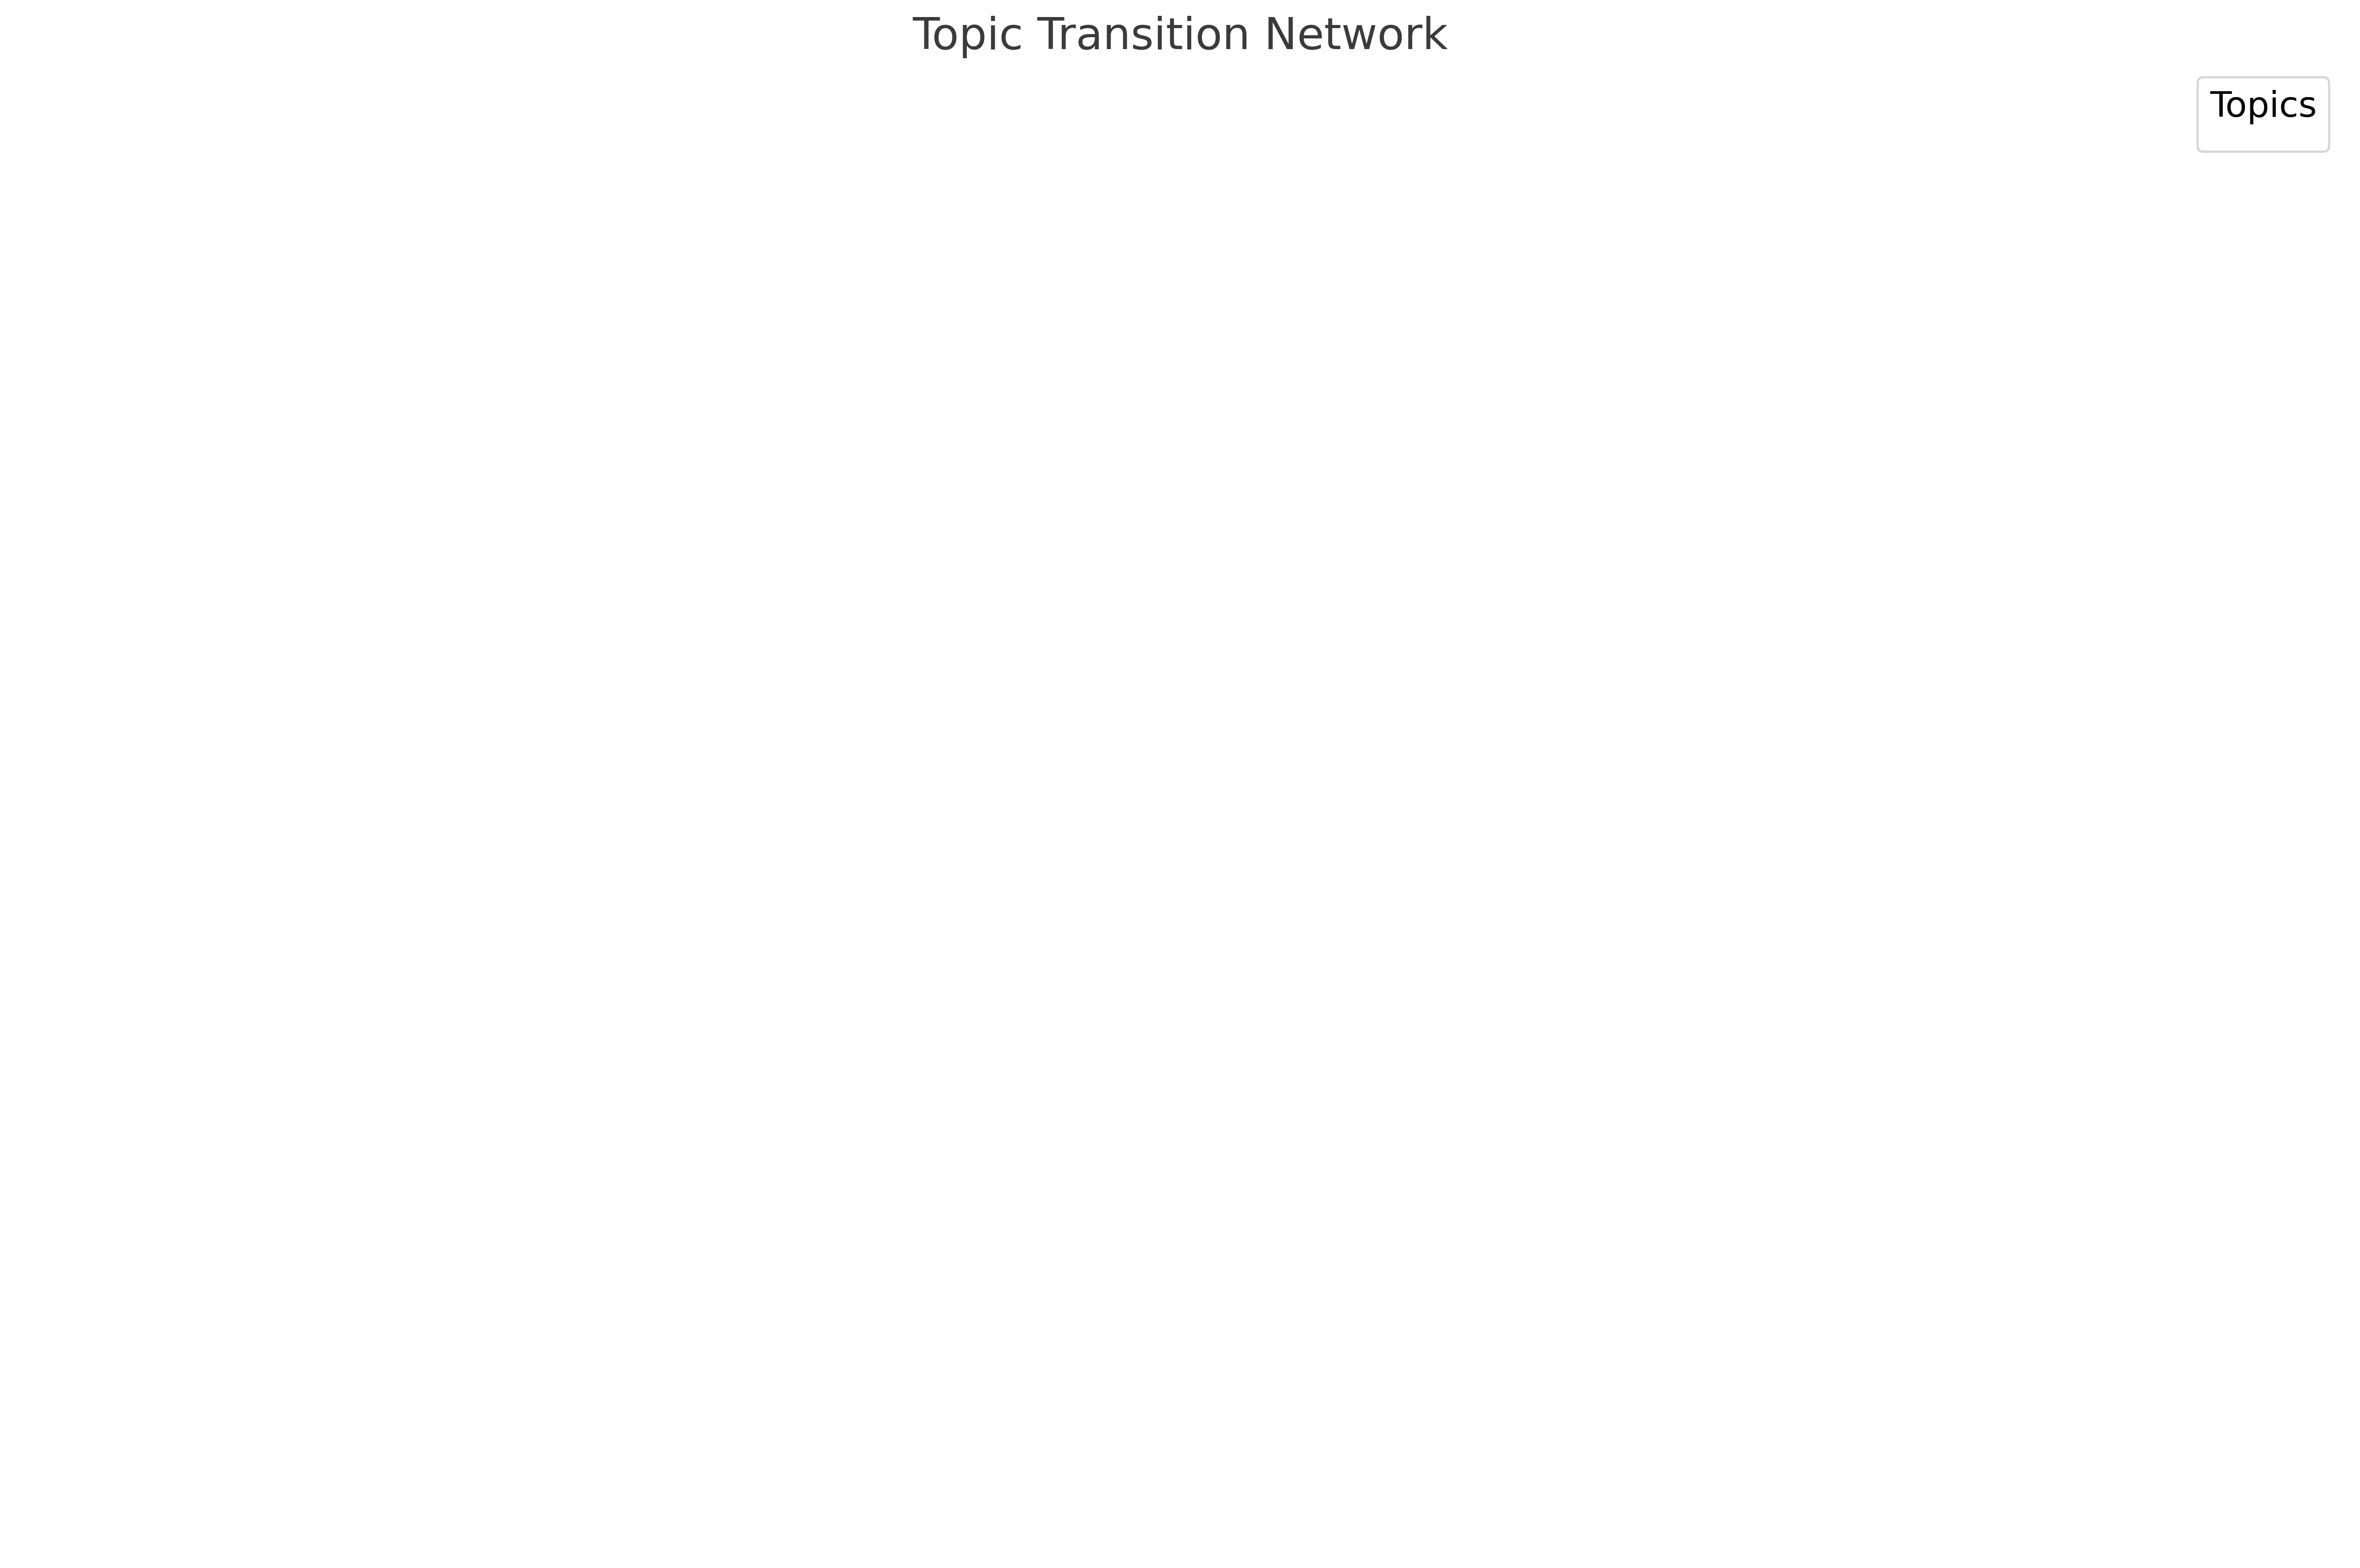

In [8]:
G_single = build_network_from_interviews(df[df["File Name"] == "S302man"], include_self_loops=False)
plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

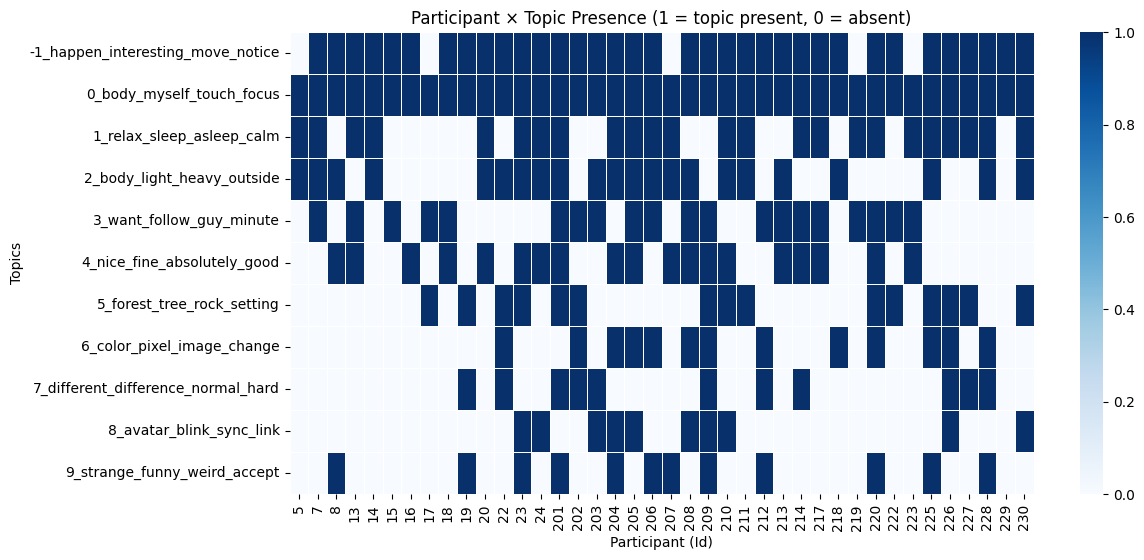

In [9]:
# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

<Axes: xlabel='File Name'>

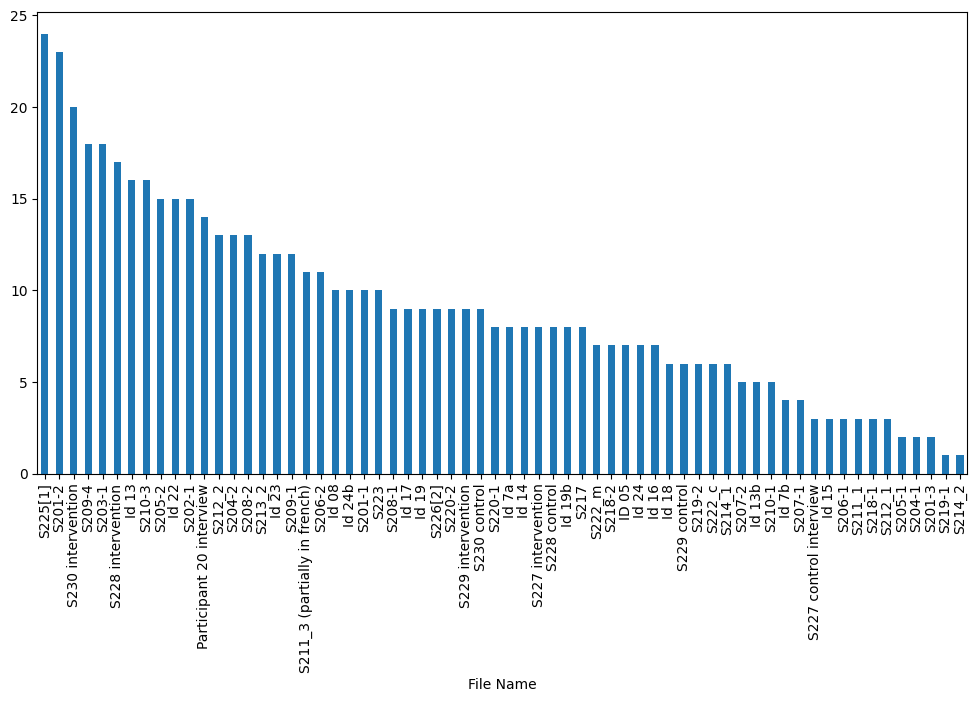

In [10]:
# Number of turn by file name (interview)
df["File Name"].value_counts().plot(kind="bar", figsize=(12, 6))